In [5]:
import os
import time
import pickle 
# spark imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import UserDefinedFunction, explode, desc
from pyspark.sql.types import StringType, ArrayType
from pyspark.mllib.recommendation import ALS

# data science imports
import math
import numpy as np
import pandas as pd
from collections import defaultdict
import pickle 

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell  
InteractiveShell.ast_node_interactivity = "all"

In [6]:
# spark config
spark = SparkSession \
    .builder \
    .appName("low value cust pdt category recommendation") \
    .config("spark.driver.maxResultSize", "96g") \
    .config("spark.driver.memory", "96g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.master", "local[12]") \
    .getOrCreate()
# get spark context
sc = spark.sparkContext

In [7]:
# path config
data_path = [DATA PATH]

In [8]:
pdt_cat = spark.read.load(os.path.join(data_path, 'pdt_cat.csv'), format='csv', header=True, inferSchema=True)
pdt_cat.show(3)

+---------------+-----------------------------+
|product_cat_num|product_category_name_english|
+---------------+-----------------------------+
|              0|              furniture_decor|
|              1|                    telephony|
|              2|                health_beauty|
+---------------+-----------------------------+
only showing top 3 rows



In [ ]:
high_value_cust_num_pdt_rating_reco = pd.read_csv('../data/processed/high_value_cust_num_pdt_rating_reco.csv')


In [ ]:
subset_ratings= high_value_cust_num_pdt_rating_reco.sample(300)
subset_ratings.to_csv('../data/processed/subset_high_value_cust_num_pdt_rating_reco.csv')

In [9]:
ratings = spark.read.load(os.path.join(data_path, 'low_value_cust_num_pdt_rating_dropna.csv'), format='csv', header=True, inferSchema=True)
ratings.show(3)

+---------------+---------------+------------+
|customer_id_num|product_cat_num|review_score|
+---------------+---------------+------------+
|              0|              0|           1|
|              0|              0|           1|
|              1|              1|           1|
+---------------+---------------+------------+
only showing top 3 rows



In [19]:
# load data
rating = sc.textFile(os.path.join(data_path, 'low_value_cust_num_pdt_rating_dropna.csv'))
# preprocess data -- only need ['customer_id,product_category_name_english,review_score']
header = rating.take(1)[0]
rating_data = rating \
    .filter(lambda line: line!=header) \
    .map(lambda line: line.split(",")) \
    .map(lambda tokens: (int(tokens[0]), int(tokens[1]), float(tokens[2]))) \
    .cache()
# check three rows
rating_data.take(3)

[(0, 0, 1.0), (0, 0, 1.0), (1, 1, 1.0)]

In [7]:
train, validation, test = rating_data.randomSplit([6, 2, 2], seed=99)
# cache data
train.cache()
validation.cache()
test.cache()

PythonRDD[31] at RDD at PythonRDD.scala:53

PythonRDD[32] at RDD at PythonRDD.scala:53

PythonRDD[33] at RDD at PythonRDD.scala:53

In [8]:
def train_ALS(train_data, validation_data, num_iters, reg_param, ranks):
    """
    Grid Search Function to select the best model based on RMSE of hold-out data
    """
    # initial
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in reg_param:
            # train ALS model
            model = ALS.train(
                ratings=train_data,    # (userID, productID, rating) tuple
                iterations=num_iters,
                rank=rank,
                lambda_=reg,           # regularization param
                seed=99)
            # make prediction
            valid_data = validation_data.map(lambda p: (p[0], p[1]))
            predictions = model.predictAll(valid_data).map(lambda r: ((r[0], r[1]), r[2]))
            # get the rating result
            ratesAndPreds = validation_data.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
            # get the RMSE
            MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
            error = math.sqrt(MSE)
            print('{} latent factors and regularization = {}: validation RMSE is {}'.format(rank, reg, error))
            if error < min_error:
                min_error = error
                best_rank = rank
                best_regularization = reg
                best_model = model
    print('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
    return best_model

In [10]:
# hyper-param config
num_iterations = 10
ranks = [8, 10, 12, 14, 16, 18, 20]
reg_params = [0.001, 0.01, 0.05, 0.1, 0.2]

# grid search and select best model
start_time = time.time()
final_model = train_ALS(train, validation, num_iterations, reg_params, ranks)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

8 latent factors and regularization = 0.001: validation RMSE is 0.881001603105722
8 latent factors and regularization = 0.01: validation RMSE is 0.692464398589371
8 latent factors and regularization = 0.05: validation RMSE is 0.6486818774646882
8 latent factors and regularization = 0.1: validation RMSE is 0.6615886643738248
8 latent factors and regularization = 0.2: validation RMSE is 0.7065078110905764
10 latent factors and regularization = 0.001: validation RMSE is 1.062568494145925
10 latent factors and regularization = 0.01: validation RMSE is 0.8389226593888023
10 latent factors and regularization = 0.05: validation RMSE is 0.6514086787267811
10 latent factors and regularization = 0.1: validation RMSE is 0.6392205402315474
10 latent factors and regularization = 0.2: validation RMSE is 0.6913544386349885
12 latent factors and regularization = 0.001: validation RMSE is 0.8716077120911546
12 latent factors and regularization = 0.01: validation RMSE is 0.7217792205584882
12 latent fac

In [11]:
def plot_learning_curve(arr_iters, train_data, validation_data, reg, rank):
    """
    Plot function to show learning curve of ALS
    """
    errors = []
    for num_iters in arr_iters:
        # train ALS model
        model = ALS.train(
            ratings=train_data,    # (userID, productID, rating) tuple
            iterations=num_iters,
            rank=rank,
            lambda_=reg,           # regularization param
            seed=99)
        # make prediction
        valid_data = validation_data.map(lambda p: (p[0], p[1]))
        predictions = model.predictAll(valid_data).map(lambda r: ((r[0], r[1]), r[2]))
        # get the rating result
        ratesAndPreds = validation_data.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
        # get the RMSE
        MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
        error = math.sqrt(MSE)
        # add to errors
        errors.append(error)

    # plot
    plt.figure(figsize=(12, 6))
    plt.plot(arr_iters, errors)
    plt.xlabel('number of iterations')
    plt.ylabel('RMSE')
    plt.title('ALS Learning Curve')
    plt.grid(True)
    plt.show()

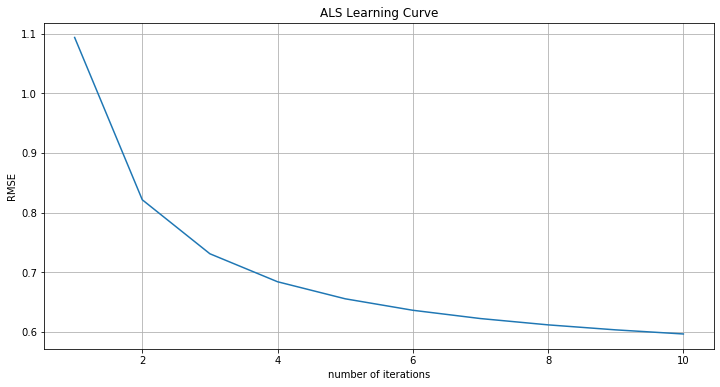

In [13]:
# create an array of num_iters
iter_array = list(range(1, 11))
# create learning curve plot
plot_learning_curve(iter_array, train, validation, 0.1, 20)

In [12]:
# make prediction using test data
test_data = test.map(lambda p: (p[0], p[1]))
predictions = final_model.predictAll(test_data).map(lambda r: ((r[0], r[1]), r[2]))
# get the rating result
ratesAndPreds = test.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
# get the RMSE
MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
error = math.sqrt(MSE)
print('The out-of-sample RMSE of rating predictions is', round(error, 4))

The out-of-sample RMSE of rating predictions is 0.6354


In [14]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
# rmse = evaluator.evaluate(ratesAndPreds)
# print("Root-mean-square error = " + str(rmse))

# Generate top 10 product recommendations for each user
userRecs = final_model.recommendProductsForUsers(10)
userRecs
# Generate top 10 user recommendations for each product
pdtRecs = final_model.recommendUsersForProducts(10)
pdtRecs

MapPartitionsRDD[12456] at mapPartitions at PythonMLLibAPI.scala:1336

MapPartitionsRDD[12465] at mapPartitions at PythonMLLibAPI.scala:1336

In [18]:
list_ratesAndPreds = [[i[0][0], i[0][1], i[1][0], i[1][1]] for i in ratesAndPreds.collect()]

In [19]:
df_ratesAndPreds = pd.DataFrame(list_ratesAndPreds, columns = ['customer_id_num', 'product_cat_num', 'review_score', 'predicted_score'])
df_ratesAndPreds.head()

,customer_id_num,product_cat_num,review_score,predicted_score
0,527,3,5.0,4.802945
1,527,3,5.0,4.802945
2,527,3,5.0,4.802945
3,527,3,5.0,4.802945
4,685,25,5.0,4.814486


In [3]:
def binary_score(x):
    if x >= 3:
        return 1
    else:
        return 0
df_ratesAndPreds['binary_review_score'] = df_ratesAndPreds['review_score'].apply(lambda x: binary_score(x))
df_ratesAndPreds['binary_predicted_score'] = df_ratesAndPreds['predicted_score'].apply(lambda x: binary_score(x))

In [4]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(df_ratesAndPreds['binary_review_score'], df_ratesAndPreds['binary_predicted_score'])
cm

array([[ 807,   10],
       [ 349, 2269]])

In [5]:
from sklearn import metrics
print(metrics.classification_report(df_ratesAndPreds['binary_review_score'], df_ratesAndPreds['binary_predicted_score']))
print("Proportion of False negatives:", (cm[1][0] /sum(sum(cm))))

              precision    recall  f1-score   support

           0       0.70      0.99      0.82       817
           1       1.00      0.87      0.93      2618

    accuracy                           0.90      3435
   macro avg       0.85      0.93      0.87      3435
weighted avg       0.92      0.90      0.90      3435

Proportion of False negatives: 0.10160116448326055


In [20]:
def spark_precision_recall_at_k(predictions, k=10, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

In [21]:
spark_als_precisions, spark_als_recalls = spark_precision_recall_at_k(list_ratesAndPreds, k=5, threshold=3)
# Precision and recall can then be averaged over all users
print(sum(prec for prec in spark_als_precisions.values()) / len(spark_als_precisions))
print(sum(rec for rec in spark_als_recalls.values()) / len(spark_als_recalls))

0.9972581276929103
0.8786117639378515


In [22]:
# df_ratesAndPreds.to_csv('../data/processed/df_ratesAndPreds_spark_als_low_value_cust.csv')
# with open('../data/processed/list_ratesAndPreds_spark_als_low_value_cust.csv', 'wb') as to_write: 
#      pickle.dump(list_ratesAndPreds, to_write)
# final_model.save(sc, '../models/spark_als_low_value_cust_model.model')

In [2]:
df_ratesAndPreds = pd.read_csv('../data/processed/df_ratesAndPreds_spark_als_low_value_cust.csv', index_col=0)

### Make product category recommendation to myself
We need to define a function that takes new user's product category rating and output top 10 recommendations

In [10]:
def get_product_cat_num(df_pdt_cat, fav_pdt_cat_list):
    """
    return all product_cat_num(s) of user's favorite pdt_cat
    
    Parameters
    ----------
    df_pdt_cat: spark Dataframe, pdt_cat data
    
    fav_pdt_cat_list: list, user's list of favorite pdt_cat
    
    Return
    ------
    product_cat_num_list: list of product_cat_num(s)
    """
    product_cat_num_list = []
    for pdt_category in fav_pdt_cat_list:
        product_cat_nums = df_pdt_cat \
            .filter(pdt_cat.product_category_name_english.like('%{}%'.format(pdt_category))) \
            .select('product_cat_num') \
            .rdd \
            .map(lambda r: r[0]) \
            .collect()
        product_cat_num_list.extend(product_cat_nums)
    return list(set(product_cat_num_list))

def add_new_user_to_data(train_data, product_cat_num_list, spark_context):
    """
    add new rows with new user, user's pdt_cat and ratings to
    existing train data

    Parameters
    ----------
    train_data: spark RDD, ratings data
    
    product_cat_num_list: list, list of product_cat_num(s)

    spark_context: Spark Context object
    
    Return
    ------
    new train data with the new user's rows
    """
    # get new user id
    new_id = train_data.map(lambda r: r[0]).max() + 1
    # get max rating
    max_rating = train_data.map(lambda r: r[2]).max()
    # create new user rdd
    user_rows = [(new_id, product_cat_num, max_rating) for product_cat_num in product_cat_num_list]
    new_rdd = spark_context.parallelize(user_rows)
    # return new train data
    return train_data.union(new_rdd)

def get_inference_data(train_data, df_pdt_cat, product_cat_num_list):
    """
    return a rdd with the userid and all pdt_cat (except ones in product_cat_num_list)

    Parameters
    ----------
    train_data: spark RDD, ratings data

    df_pdt_cat: spark Dataframe, pdt_cat data
    
    product_cat_num_list: list, list of product_cat_num(s)

    Return
    ------
    inference data: Spark RDD
    """
    # get new user id
    new_id = train_data.map(lambda r: r[0]).max() + 1
    # return inference rdd
    return df_pdt_cat.rdd \
        .map(lambda r: r[0]) \
        .distinct() \
        .filter(lambda x: x not in product_cat_num_list) \
        .map(lambda x: (new_id, x))

def make_recommendation(best_model_params, ratings_data, df_pdt_cat, 
                        fav_pdt_cat_list, n_recommendations, spark_context):
    """
    return top n pdt_cat recommendation based on user's input list of favorite pdt_cat


    Parameters
    ----------
    best_model_params: dict, {'iterations': iter, 'rank': rank, 'lambda_': reg}

    ratings_data: spark RDD, ratings data

    df_pdt_cat: spark Dataframe, pdt_cat data

    fav_pdt_cat_list: list, user's list of favorite pdt_cat

    n_recommendations: int, top n recommendations

    spark_context: Spark Context object

    Return
    ------
    list of top n pdt_cat recommendations
    """
    # modify train data by adding new user's rows
    product_cat_num_list = get_product_cat_num(df_pdt_cat, fav_pdt_cat_list)
    train_data = add_new_user_to_data(ratings_data, product_cat_num_list, spark_context)
    
    # train best ALS
    model = ALS.train(
        ratings=train_data,
        iterations=best_model_params.get('iterations', None),
        rank=best_model_params.get('rank', None),
        lambda_=best_model_params.get('lambda_', None),
        seed=99)
    
    # get inference rdd
    inference_rdd = get_inference_data(ratings_data, df_pdt_cat, product_cat_num_list)
    print(inference_rdd.take(10))
    # inference
    predictions = model.predictAll(inference_rdd).map(lambda r: (r[1], r[2]))
    
    # get top n product_cat_num
    topn_rows = predictions.sortBy(lambda r: r[1], ascending=False).take(n_recommendations)
    topn_ids = [r[0] for r in topn_rows]
    
    # return pdt_cat titles
    return df_pdt_cat.filter(pdt_cat.product_cat_num.isin(topn_ids)) \
                    .select('product_category_name_english') \
                    .rdd \
                    .map(lambda r: r[0]) \
                    .collect()

In [14]:
# my favorite pdt_cat
my_favorite_pdt_cat = ['bed_bath_table']

# get recommends
recommends = make_recommendation(
    best_model_params={'iterations': 10, 'rank': 20, 'lambda_': 0.1}, 
    ratings_data=rating_data, 
    df_pdt_cat=pdt_cat, 
    fav_pdt_cat_list=my_favorite_pdt_cat, 
    n_recommendations=10, 
    spark_context=sc)

print('Recommendations for {}:'.format(my_favorite_pdt_cat[0]))
for i, pdt_category in enumerate(recommends):
    print('{0}: {1}'.format(i+1, pdt_category))

[(72993, 0), (72993, 1), (72993, 2), (72993, 3), (72993, 4), (72993, 5), (72993, 6), (72993, 7), (72993, 8), (72993, 9)]
Recommendations for bed_bath_table:
1: fixed_telephony
2: furniture_bedroom
3: small_appliances
4: home_comfort_2
5: musical_instruments
6: home_appliances
7: books_imported
8: fashion_sport
9: arts_and_craftmanship
10: construction_tools_lights


In [16]:
rating = sc.textFile(os.path.join(data_path, 'mid_value_cust_num_pdt_rating_dropna.csv'))
# preprocess data -- only need ['customer_id,product_category_name_english,review_score']
header = rating.take(1)[0]
rating_data = rating \
    .filter(lambda line: line!=header) \
    .map(lambda line: line.split(",")) \
    .map(lambda tokens: (int(tokens[0]), int(tokens[1]), float(tokens[2]))) \
    .cache()
# check three rows
rating_data.take(3)

[(0, 0, 5.0), (1, 1, 5.0), (2, 2, 5.0)]

In [17]:
# my favorite pdt_cat
my_favorite_pdt_cat = ['bed_bath_table']

# get recommends
recommends = make_recommendation(
    best_model_params={'iterations': 10, 'rank': 20, 'lambda_': 0.1}, 
    ratings_data=rating_data, 
    df_pdt_cat=pdt_cat, 
    fav_pdt_cat_list=my_favorite_pdt_cat, 
    n_recommendations=10, 
    spark_context=sc)

print('Recommendations for {}:'.format(my_favorite_pdt_cat[0]))
for i, pdt_category in enumerate(recommends):
    print('{0}: {1}'.format(i+1, pdt_category))

[(23065, 0), (23065, 1), (23065, 2), (23065, 3), (23065, 4), (23065, 5), (23065, 6), (23065, 7), (23065, 8), (23065, 9)]
Recommendations for bed_bath_table:
1: garden_tools
2: fashio_female_clothing
3: books_technical
4: music
5: small_appliances
6: home_comfort_2
7: musical_instruments
8: christmas_supplies
9: furniture_mattress_and_upholstery
10: arts_and_craftmanship


In [21]:
with open('../data/processed/bed_bath_table_recommends_spark_als_low_value_cust.csv', 'wb') as to_write: 
     pickle.dump(recommends, to_write)

Modelling using Surprise library

In [26]:
from collections import defaultdict
from surprise import Reader
from surprise import Dataset
from surprise import NMF, SVD, SVDpp, SlopeOne, CoClustering
from surprise.accuracy import rmse
from surprise.model_selection import KFold
from surprise.model_selection import train_test_split, cross_validate, GridSearchCV

In [27]:
ratings_df = pd.read_csv('../data/processed/low_value_cust_num_pdt_rating_dropna.csv')
ratings_df.head(3)

,customer_id_num,product_cat_num,review_score
0,0,0,1
1,0,0,1
2,1,1,1


In [29]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_df, reader)

In [30]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=5, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

In [31]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
surprise_results

,test_rmse,fit_time,test_time
Algorithm,,,
SlopeOne,1.171577,0.717192,0.132396
CoClustering,1.174814,6.244996,0.074039
NMF,1.175712,7.299871,0.119756
SVD,1.196481,4.176077,0.104358
SVDpp,1.204267,7.937701,0.129223


Used Spark's ALS due to its lower RMSE cf. to using ML models using Surprise